Setup and Data Extraction



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Eyes.zip -d /content/

Archive:  /content/gdrive/MyDrive/Eyes.zip
   creating: /content/Eyes/
   creating: /content/Eyes/test/
   creating: /content/Eyes/test/cataract/
 extracting: /content/Eyes/test/cataract/cataract-100.jpg  
 extracting: /content/Eyes/test/cataract/cataract-101.jpg  
  inflating: /content/Eyes/test/cataract/cataract-103.jpg  
 extracting: /content/Eyes/test/cataract/cataract-110.jpg  
  inflating: /content/Eyes/test/cataract/cataract-117.jpg  
 extracting: /content/Eyes/test/cataract/cataract-121.jpg  
  inflating: /content/Eyes/test/cataract/cataract-122.jpg  
 extracting: /content/Eyes/test/cataract/cataract-13.jpg  
 extracting: /content/Eyes/test/cataract/cataract-135.jpg  
  inflating: /content/Eyes/test/cataract/cataract-143.jpg  
 extracting: /content/Eyes/test/cataract/cataract-168.jpg  
 extracting: /content/Eyes/test/cataract/cataract-179.jpg  
  inflating: /content/Eyes/test/cataract/cataract-190.jpg  
  inflating: /content/Eyes/test/cataract/cataract-2.jpg  
 extracting: /con

Importing Neccesary Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

Data Preprocessing

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/train",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Eyes/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 560 files belonging to 2 classes.
Found 120 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Visualizing the data

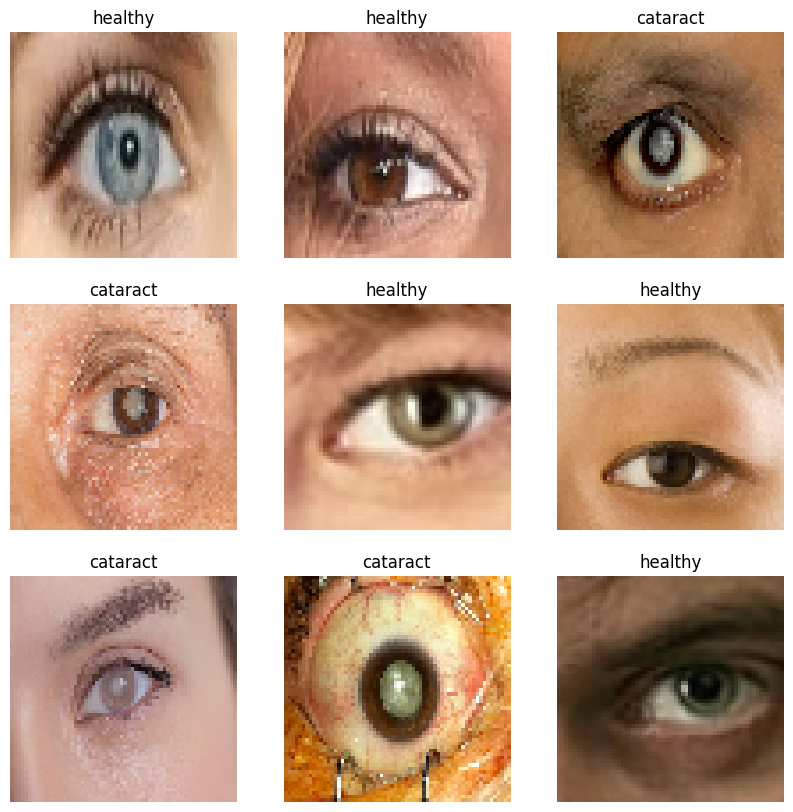

In [ ]:
class_names = ["cataract", "healthy"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Normalize the datasets

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Define the model

In [ ]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2)
])

Compile the model

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Train the model

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
25/25 [==============================] - 65s 2s/step - loss: 0.3139 - accuracy: 0.8543 - val_loss: 0.1385 - val_accuracy: 0.9356
Epoch 2/10
25/25 [==============================] - 65s 2s/step - loss: 0.1113 - accuracy: 0.9673 - val_loss: 0.0932 - val_accuracy: 0.9657
Epoch 3/10
25/25 [==============================] - 67s 3s/step - loss: 0.0704 - accuracy: 0.9774 - val_loss: 0.0652 - val_accuracy: 0.9828
Epoch 4/10
25/25 [==============================] - 57s 2s/step - loss: 0.0455 - accuracy: 0.9862 - val_loss: 0.0493 - val_accuracy: 0.9871
Epoch 5/10
25/25 [==============================] - 58s 2s/step - loss: 0.0379 - accuracy: 0.9925 - val_loss: 0.0340 - val_accuracy: 0.9914
Epoch 6/10
25/25 [==============================] - 73s 3s/step - loss: 0.0263 - accuracy: 0.9950 - val_loss: 0.0290 - val_accuracy: 0.9957
Epoch 7/10
25/25 [==============================] - 60s 2s/step - loss: 0.0228 - accuracy: 0.9937 - val_loss: 0.0222 - val_accuracy: 0.9957
Epoch 8/10
25/25 [==

Evaluate the model




In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 11s 874ms/step - loss: 0.0204 - accuracy: 0.9911


[0.02043958194553852, 0.9911110997200012]

Tflite Conversion


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

Average runtime calculation


In [ ]:
import time
# Define a function to measure the execution time of a single run
def measure_execution_time(model, input_data):
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time
# Run multiple iterations and measure the execution time for each iteration
num_iterations = 5  
total_execution_time = 0

for _ in range(num_iterations):
    execution_time = measure_execution_time(model, test_ds)
    total_execution_time += execution_time

average_execution_time = total_execution_time / num_iterations

print("Average Execution Time:", average_execution_time)

8/8 [==============================] - 12s 858ms/step
Average Execution Time: 17.438131856918336


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 128)               163968    
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 2422210 (9.24 MB)
Trainable params: 164226 (641.51 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Calculate precision, recall, and F1 score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Predict classes for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1/1 [==============================] - 1s 1s/step
Precision: 0.9912684365781711
Recall: 0.9911111111111112
F1 Score: 0.9911114622840286


Confusion matrix

1/1 [==============================] - 0s 71ms/step


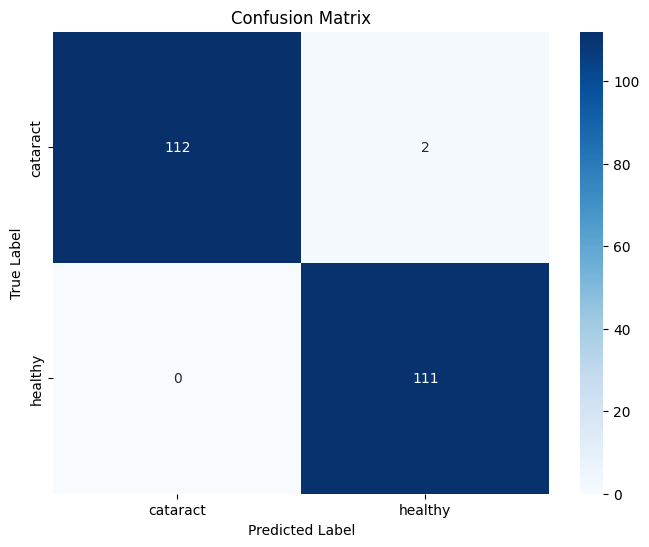

In [ ]:
from tensorflow.keras.utils import to_categorical

# Assuming class_names is defined
class_names = ["cataract", "healthy"]

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels from one-hot encoding to label format
y_true_labels = np.array(y_true)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


ROC curve for each class

1/1 [==============================] - 0s 57ms/step


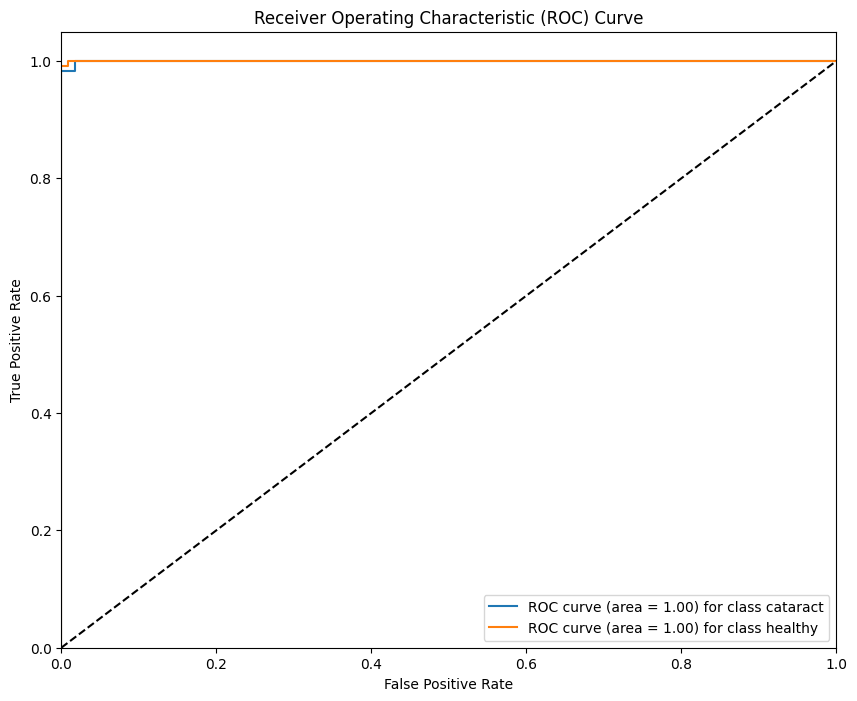

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Predict probabilities for the test dataset
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(predictions)

# Convert the true labels to one-hot encoding
y_true = to_categorical(y_true, num_classes=len(class_names))

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()